In [2]:
import PIL
from scipy.io import savemat, loadmat
import numpy as np
import os
import h5py
from svhn_utils import file2tensor, parse_digit_struct
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

%matplotlib inline

<ol>
<li><a href="#Cropping-Resizing-and-Arrayifying-Photos">Cropping Resizing and Arrayifying Photos</a></li>
<li><a href="#Parsing-digitStruct-and-Getting-Labels">Parsing digitStruct and Getting Labels</a></li>
<li><a href="#Saving-to-File">Saving to File</a></li>
</ol>

# Cropping Resizing and Arrayifying Photos

In [4]:
!dir "D:/Data/SVHN/images"

 Volume in drive D is SSD
 Volume Serial Number is 8457-8E77

 Directory of D:\Data\SVHN\images

07/14/2017  02:26 PM    <DIR>          .
07/14/2017  02:26 PM    <DIR>          ..
07/14/2017  02:26 PM    <DIR>          test
07/14/2017  02:37 PM    <DIR>          train
               0 File(s)              0 bytes
               4 Dir(s)  220,622,073,856 bytes free


In [5]:
train_files = [os.path.join('D:/Data/SVHN/images/train/', x) for x in os.listdir('D:/Data/SVHN/images/train/') if x[-3:]=='png']
test_files = [os.path.join('D:/Data/SVHN/images/test/', x) for x in os.listdir('D:/Data/SVHN/images/test/') if x[-3:] == 'png']
train_files[0]

'D:/Data/SVHN/images/train/1.png'

Since most of the photos have a ratio of ~0.5, and I don't want to distort the photos, I will pad the images to have a ratio of 0.5 and resize to 64x32

In [6]:
%%time 
sizes = []
ratios = []
for f in train_files:
    size = PIL.Image.open(f).size    
    sizes.append(size)
    ratios.append(size[1] / size[0])
print(np.mean(ratios))
print(np.max(ratios))
print(1/np.min(ratios))

0.449952175112
1.09677419355
5.53488372093
Wall time: 3.29 s


In [7]:
import pandas as pd
df = pd.DataFrame(sizes)
df.columns = ['width', 'height']
df['filename'] = train_files #[x.split('/')[-1] for x in train_files]

In [8]:
df['ratio'] = df['width'] / df['height'] 
df

,width,height,filename,ratio
0,741,350,D:/Data/SVHN/images/train/1.png,2.117143
1,74,37,D:/Data/SVHN/images/train/10.png,2.000000
2,67,27,D:/Data/SVHN/images/train/100.png,2.481481
3,44,21,D:/Data/SVHN/images/train/1000.png,2.095238
4,137,62,D:/Data/SVHN/images/train/10000.png,2.209677
5,66,33,D:/Data/SVHN/images/train/10001.png,2.000000
6,295,117,D:/Data/SVHN/images/train/10002.png,2.521368
7,68,28,D:/Data/SVHN/images/train/10003.png,2.428571
8,95,41,D:/Data/SVHN/images/train/10004.png,2.317073
9,140,58,D:/Data/SVHN/images/train/10005.png,2.413793


In [9]:
df['scale'] = np.sqrt(df['width']*df['height'])

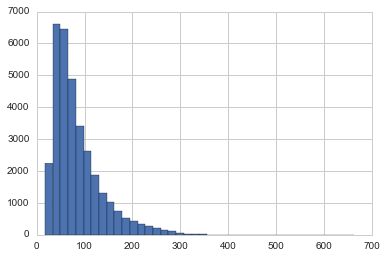

In [10]:
df['scale'].hist(bins=40)
plt.show()

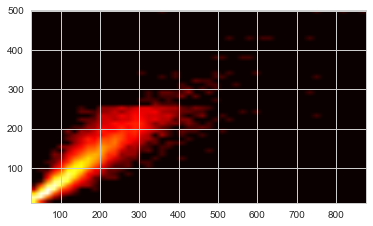

In [11]:
# plt.scatter(df['width'], df['height'])
H, xedges, yedges = np.histogram2d(df['width'], df['height'], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.imshow(np.log(1+H), origin='lower', extent=extent, cmap='hot')
plt.show()

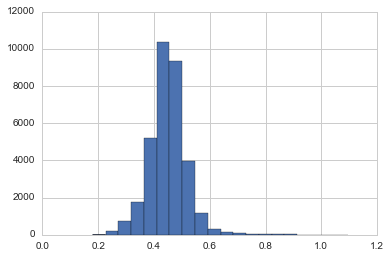

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(ratios, bins=20)
plt.show()

In [13]:
%%time
train_data = np.array([file2tensor(f) for f in train_files])
test_data = np.array([file2tensor(f) for f in test_files])
print(train_data.shape)

(33402, 64, 128, 3)
Wall time: 37.9 s


In [14]:
len(train_data)

33402

In [15]:
import time
time.sleep(1)
from IPython.display import clear_output

In [16]:
for i in np.random.randint(0, 33401, size=30):
    scale = 10
    plt.figure(figsize=(128/scale, 64/scale))
    plt.imshow(train_data[i])
    plt.grid(False)
    plt.title(train_files[i])
    plt.show()
    
    time.sleep(2)
    clear_output()

D:/Data/SVHN/images/train/11799.png


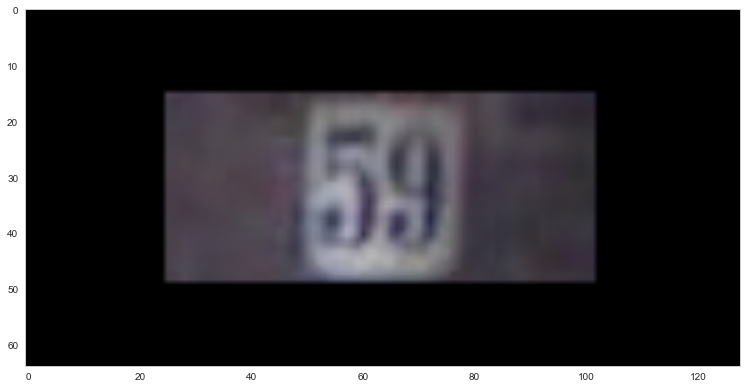

In [17]:
i = 2000
print(train_files[i])
scale = 10
plt.figure(figsize=(128/scale, 64/scale))
plt.imshow(train_data[i])
plt.grid(False)
plt.show()

This one happens to be useless regardless of the ratio/cropping, and even so it's not bad

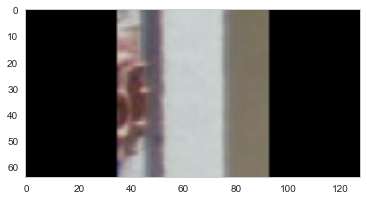

In [18]:
plt.imshow(train_data[np.argmax(ratios)])
plt.grid(False)

This one actually seems okay, so I'm declaring that we're good!

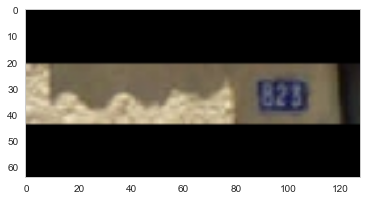

In [19]:
plt.imshow(train_data[np.argmin(ratios)])
plt.grid(False)

# Parsing digitStruct and Getting Labels

In [21]:
train_digit_struct = h5py.File('D:/Data/SVHN/images/train/digitStruct.mat', mode='r')
test_digit_struct = h5py.File('D:/Data/SVHN/images/test/digitStruct.mat', mode='r')

In [22]:
%%time
train_bbox_dicts = parse_digit_struct(train_digit_struct)
test_bbox_dicts = parse_digit_struct(test_digit_struct)

Wall time: 2min 40s


[1, 9]


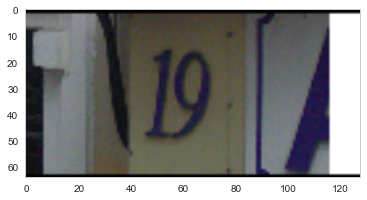

In [23]:
train_labels = []
for filename in train_files:
    basename = os.path.basename(filename)
    try:
        train_labels.append([int(box['label']) for box in train_bbox_dicts[basename]])
    except Exception as e:
        print(basename)
        raise e
print(train_labels[0])
plt.imshow(train_data[0])
plt.grid(False)

[5]


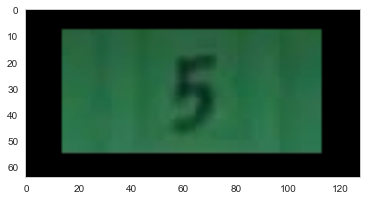

In [24]:
test_labels = []
for filename in test_files:
    basename = os.path.basename(filename)
    try:
        test_labels.append([int(box['label']) for box in test_bbox_dicts[basename]])
    except Exception as e:
        print(basename)
        raise e
print(test_labels[0])
plt.imshow(test_data[0])
plt.grid(False)

In [25]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Saving to File

In [26]:
if not os.path.exists('D:/Data/SVHN/tensors2/'):
    os.mkdir('D:/Data/SVHN/tensors2/')
savemat('D:/Data/SVHN/tensors2/train.mat', {'data': train_data, 
                                          'labels': train_labels, 
                                           'files': np.array(train_files)})
savemat('D:/Data/SVHN/tensors2/test.mat', {'data': test_data, 
                                          'labels': test_labels,
                                          'files': np.array(test_files)})

In [27]:
import pickle
with open('D:/Data/SVHN/tensors2/train.pkl', 'wb') as f:
    pickle.dump({'data': train_data,
                 'labels': train_labels,
                 'files': train_files},
                f)
    
with open('D:/Data/SVHN/tensors2/test.pkl', 'wb') as f:
    pickle.dump({'data': test_data,
                 'labels': test_labels,
                 'files': test_files},
               f)